<h1>Neural Machine Translation</h1>
===================================================
<h2>Using LSTM - Encoder Decoder architecture</h2>

<p><strong>Note:</strong> The following code is tested on environment accelerator: <strong>GPU P100</strong> and requires it for proper functioning.
Not using it might lead to error.</p>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# System libraries
import re
import gc
import time

# Third party libraries
import numpy as np # linear algebra
import pickle as pk # data save and restore library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # Deep learning library, provides platform for keras
from string import digits, punctuation # Data cleaning
from sklearn.utils import shuffle # To shuffle dataframe before input
from sklearn.model_selection import train_test_split as tts # Dividing dataframe into test , train sets
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense # keras library working on tensorflow, to create models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 500)

# Persistent Working directory: (/kaggle/working/) [20 GB max]
# Temporary Working directory: (/kaggle/temp/)

<h3>Reading dataset and removing unnecessary rows</h3>

In [2]:
# Reading Dataset
directory_path = '/kaggle/input/samanantar-english-hindi-parallel-corpus/'
file_en, file_hi = open(directory_path+'train.en'), open(directory_path+'train.hi')
dataset_en, dataset_hi = file_en.read().split('\n'), file_hi.read().split('\n')
len(dataset_en), len(dataset_hi)
df_en = pd.DataFrame(dataset_en, columns=['en'])
df_hi = pd.DataFrame(dataset_hi, columns=['hi'])
df = pd.concat([df_en, df_hi], axis=1)

In [3]:
df = df.drop(df.index[700000:])

In [4]:
del(dataset_en)
del(dataset_hi)
del(file_en)
del(file_hi)
del(df_en)
del(df_hi)
gc.collect()

236

<h3>Text pre-processing</h3>
<p>Case folding (lower-casing all characters), Removing quotes, extra whitespaces, digits, punctuations, and <br/>  adding start and end indicator to target sentence</p>

In [5]:
# Lowercase all characters
df['en']=df['en'].apply(lambda x: x.lower())
df['hi']=df['hi'].apply(lambda x: x.lower())

In [6]:
# Remove quotes
df['en']=df['en'].apply(lambda x: re.sub("'", '', x))
df['hi']=df['hi'].apply(lambda x: re.sub("'", '', x))

In [7]:
exclude = set([*(punctuation), '“', '”', '‘', '’', '।', '\xa0']) # set(punctuation) # Set of all special characters
# Remove all the special characters
df['en']=df['en'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df['hi']=df['hi'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [8]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
df['en']=df['en'].apply(lambda x: x.translate(remove_digits))
df['hi']=df['hi'].apply(lambda x: x.translate(remove_digits))

df['hi'] = df['hi'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))
df['hi'] = df['hi'].apply(lambda x: re.sub("[a-zA-Z]", "", x))

In [9]:
# Remove extra spaces
df['en']=df['en'].apply(lambda x: x.strip())
df['hi']=df['hi'].apply(lambda x: x.strip())
df['en']=df['en'].apply(lambda x: re.sub(" +", " ", x))
df['hi']=df['hi'].apply(lambda x: re.sub(" +", " ", x))

In [10]:
# Add start and end tokens to target sequences
df['hi'] = df['hi'].apply(lambda x : 'START_ '+ x + ' _END')

<h4>Adding length of sentence column to dataframe</h4>
<p>Useful to filter out extra long sentences</p>

In [11]:
df['len_en']=df['en'].apply(lambda x:len(x.split(" ")))
df['len_hi']=df['hi'].apply(lambda x:len(x.split(" ")))

In [12]:
df=df[df['len_en']<=10]
df=df[df['len_hi']<=10]
df=df[df['len_en']>2]
df=df[df['len_hi']>2]

In [13]:
df=df.sample(n=50000, random_state=21, replace=True)
df.shape

(50000, 4)

In [14]:
df[['len_en', 'len_hi']].describe()

,len_en,len_hi
count,50000.000000,50000.000000
mean,5.739500,7.989340
std,1.866266,1.622701
min,3.000000,3.000000
25%,4.000000,7.000000
50%,6.000000,8.000000
75%,7.000000,9.000000
max,10.000000,10.000000


<h4>Displaying resultant dataset rows</h4>

In [15]:
df.head()

,en,hi,len_en,len_hi
390675,but it isnt overwhelming,START_ पर उसमें अधिक दमखम नहीं होता है _END,4,9
343125,the film is directed by apoorva lakhia,START_ फिल्म का निर्देशन किया है अपूर्व लाखिया ने _END,7,10
676306,there is national pride and selfrespect in the name savarkar,START_ सावरकर नाम में राष्ट्राभियान और स्वाभिमान है _END,10,9
396263,roseau dominica may,START_ रोहतक मई निस _END,3,5
309034,some say they are from babylonia,START_ कुछ इसे बलोची भी ठहराते हैं _END,6,8


<h3>Preparing vocabulary for both source and target language</h3>
<p>To get estimation of total words in vocab and for encoding-decoding sentences</p>

In [16]:
### Get English and Hindi Vocabulary
vocab_en=set()
for eng in df['en']:
    for word in eng.split():
        if word not in vocab_en:
            vocab_en.add(word)

vocab_hi=set()
for hin in df['hi']:
    for word in hin.split():
        if word not in vocab_hi:
            vocab_hi.add(word)

In [17]:
# Displaying vocabulary size of each language
print('En: ', len(vocab_en), '\nHi: ', len(vocab_hi))

En:  18839 
Hi:  24245


In [18]:
max_length_src=max(df['len_hi'])
max_length_tar=max(df['len_en'])

In [19]:
input_words = sorted(list(vocab_en))
target_words = sorted(list(vocab_hi))
num_encoder_tokens = len(vocab_en)
num_decoder_tokens = len(vocab_hi)
num_encoder_tokens, num_decoder_tokens
del(vocab_en)
del(vocab_hi)
gc.collect()

0

In [20]:
num_decoder_tokens += 1 #for zero padding

In [21]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [22]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [23]:
df = shuffle(df)
df.head(10)

,en,hi,len_en,len_hi
386947,narendra modi has no understanding of economics,START_ मोदी को अर्थव्यवस्था की समझ नहीं है _END,7,9
623276,hear it hear it,START_ हम कैसे सुनते बोलते हैं _END,4,7
696222,it is indeed special to be here,START_ यहां की सैर करने का वाकई स्पेशल है _END,7,10
49703,indiatimes news network,START_ इंडियाटाइम्स न्यूज नेटवर्क _END,3,5
40290,tendulkar ruled out of sri lanka odi series,START_ सचिन तेंदुलकर की वनडे टीम में वापसी _END,8,9
417294,they didnt succeed,START_ इसमें वे सफल नहीं रहे _END,3,7
309228,efforts are being made to find a solution,START_ समाधान के लिए प्रयासरत _END,8,6
609159,the chhattisgarh public distribution system control order,START_ छत्तीसगढ़ सार्वजनिक वितरण प्रणाली नियंत्रण आदेश _END,7,8
393465,this plan also offers free sms per day,START_ इस प्लान में एसएमएस भी फ्री मिलेंगे _END,8,9
178950,it was not terrorism,START_ वह आतंकी घटना नहीं थी _END,4,7


<h3>Dataset splitting into train and test set</h3>
<p>Useful for testing of the model on unseen data</p>

In [24]:
X, y = df['en'], df['hi']
X_train, X_test, y_train, y_test = tts(X, y, test_size = 6000,random_state=42)
X_test, X_val, y_test, y_val = tts(X_test, y_test, test_size = 1000,random_state=42)

X_train.reset_index(drop=True)
X_test.reset_index(drop=True)
X_val.reset_index(drop=True)

y_train.reset_index(drop=True)
y_test.reset_index(drop=True)
y_val.reset_index(drop=True)

X_train.shape, X_test.shape, X_val.shape

((44000,), (5000,), (1000,))

<h3>Data Generator</h3>

In [25]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        if t>19:
                            print(f'index: {i+j} target_text: {target_text}')
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

<h3>Encoder-Decoder Architecture</h3>

In [26]:
# LSTM Units
latent_dim=640

<h4>Encoder layer</h4>

In [27]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

<h4>Decoder layer</h4>

In [28]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

<h4>Model compilation and summary</h4>

In [29]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 640)            1205696   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_1 (Embedding)     (None, None, 640)            1551744   ['input_2[0][0]']         

<h4>Training parameters initialization and Model training</h4>

In [31]:
# Model training vars initialization
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 64
max_epochs = 101 #51 #100

In [32]:
# Defining keras callback to prevent memory overflow
class MClear(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

In [33]:
# Model training
timestamp = time.strftime("%d%m%Y%H%M%S", time.gmtime())

model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=max_epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto'), MClear()] #, restore_best_weights=True)]
                   )

/tmp/ipykernel_42/3174764773.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),


Epoch 1/101
687/687 [==============================] - 98s 125ms/step - loss: 6.5474 - val_loss: 6.3196
Epoch 2/101
687/687 [==============================] - 79s 111ms/step - loss: 6.1564 - val_loss: 6.0410
Epoch 3/101
687/687 [==============================] - 77s 110ms/step - loss: 5.8342 - val_loss: 5.7566
Epoch 4/101
687/687 [==============================] - 78s 111ms/step - loss: 5.5483 - val_loss: 5.5249
Epoch 5/101
687/687 [==============================] - 77s 109ms/step - loss: 5.2888 - val_loss: 5.3311
Epoch 6/101
687/687 [==============================] - 77s 109ms/step - loss: 5.0313 - val_loss: 5.1328
Epoch 7/101
687/687 [==============================] - 77s 110ms/step - loss: 4.7780 - val_loss: 4.9870
Epoch 8/101
687/687 [==============================] - 77s 109ms/step - loss: 4.5337 - val_loss: 4.8236
Epoch 9/101
687/687 [==============================] - 77s 110ms/step - loss: 4.3006 - val_loss: 4.6998
Epoch 10/101
687/687 [==============================] - 77s 109m

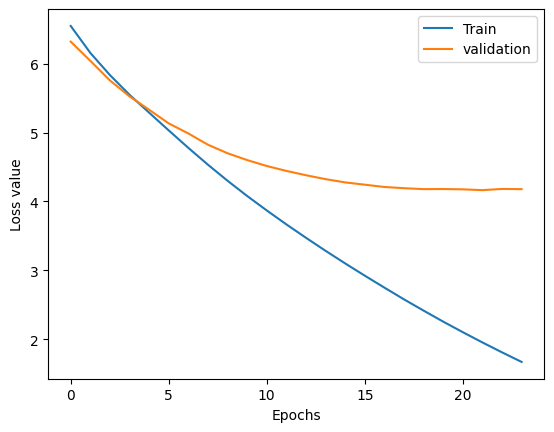

<Figure size 3840x2880 with 0 Axes>

In [34]:
# Plotting model training journey
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.legend(['Train','validation'])
plt.figure(dpi=600)
plt.savefig(f'train_validation_plot_{timestamp}.png')
plt.show()

<h3>Prediction phase</h3>
<p>We will now predict translations for Training, Test and Validation data, and calculate different performance metrices for them.</p>

In [35]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [36]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq, verbose = 0)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose = 0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

<h4>On Training data</h4>

In [37]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
prediction_df_train = pd.DataFrame({'input_sentence': [], 'translation': [], 'ref_translation': []}, columns=['Input sentence', 'Translation', 'Reference Translation'])
for k in range(1000):
    (input_seq, actual_output), _ = next(train_gen)
    input_sentence = X_train[k:k+1].values[0]
    translation = decode_sequence(input_seq)[:-4]
    ref_translation = y_train[k:k+1].values[0][6:-4]
    prediction_df_train.loc[k] = [input_sentence, translation, ref_translation]

In [38]:
prediction_df_train.head(20)

,Input sentence,Translation,Reference Translation
0,bank of baroda,बैंक ऑफ बैंक,बैंक ऑफ बड़ौदा
1,this statement is not true,यह मामला अभी भी नहीं है,यह खबर सच नहीं है
2,to be less than a away from,से से ज्यादा दूर होना,से छोटी होगी
3,the indian economys health is not good,भारतीय बैंकिंग उद्योग की सेहत बहुत अच्छी है,भारतीय बैंकिंग उद्योग की सेहत वैसे अच्छी है
4,jewish and arab christian brothers,उपस्थित और अरबी भाई की जगह,यहूदी और अरबी मसीही भाई
5,what could be even worse than that,फिर भी क्या कर लिया था,इससे ज़्यादा वीभत्स और क्या हो सकता है
6,what we read at hebrews is significant,हमें कैसे कैसे होता है,इब्रानियों में लिखी बात बहुत मायने रखती है
7,once a surprise occurred,एक बार एक हादसा हुआ,एक बार एक आश्चर्यजनक घटना घटी
8,the house was adjourned till noon,यहां रात तक स्थगित की थी,लोकसभा की कार्यवाही बजे तक स्थगित
9,agriculture is their only livelihood,उनके प्रमुख जीवन का एक महत्वपूर्ण है,उनके जीवनयापन का इकलौता स्रोत खेती है


<h4>On Test Data</h4>

In [39]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
prediction_df_test = pd.DataFrame({'input_sentence': [], 'translation': [], 'ref_translation': []}, columns=['Input sentence', 'Translation', 'Reference Translation'])
for k in range(1000):
    (input_seq, actual_output), _ = next(test_gen)
    input_sentence = X_test[k:k+1].values[0]
    translation = decode_sequence(input_seq)[:-4]
    ref_translation = y_test[k:k+1].values[0][6:-4]
    prediction_df_test.loc[k] = [input_sentence, translation, ref_translation]

In [40]:
prediction_df_test.head(20)

,Input sentence,Translation,Reference Translation
0,help farmers in every way possible,क्या मदद के लिए बेहतर बेहतर रहेगा,किसानों की हरसंभव मदद करें
1,this movie has been in talks for a long time,यह फिल्म बहुत समय पर काफी समय है,यह फिल्म काफी समय से चर्चा में है
2,it was his first such stroke of the day,पहले दिन का पहला पहला बार था,यह उनका पहला इस तरह का कंपटीशन था
3,phnom penh december,यमुनानगर दिसंबर हप्र,अंबाला दिसंबर निस
4,airline safety car safety,आनंद कॉलेज का मोबाइल चोरी,हवाई जहाज सुरक्षा कार सुरक्षा
5,hear it hear it,हम कैसे सुनते रहे हैं,हम कैसे सुनते बोलते हैं
6,have registered a case,एक बड़ी केस दर्ज,पर दर्ज हुआ केस
7,let us start from the beginning,आइए हम शुरू कर रहे से,आइए हम शुरू से आरम्भ करें
8,it is a part of the game,यह एक बड़ा हिस्सा है,यह खेल का हिस्सा है
9,rss is only in india,चीन में भारत का एक बड़ा है,आरएसएस का अस्तित्व सिर्फ़ भारत में है


<h4>On Validation Data - for self verification</h4>

In [41]:
val_gen = generate_batch(X_val, y_val, batch_size = 1)
prediction_df_val = pd.DataFrame({'input_sentence': [], 'translation': [], 'ref_translation': []}, columns=['Input sentence', 'Translation', 'Reference Translation'])
for k in range(min(len(X_val),1000)):
    (input_seq, actual_output), _ = next(val_gen)
    input_sentence = X_val[k:k+1].values[0]
    translation = decode_sequence(input_seq)[:-4]
    ref_translation = y_val[k:k+1].values[0][6:-4]
    prediction_df_val.loc[k] = [input_sentence, translation, ref_translation]

In [42]:
prediction_df_val.head(50)

,Input sentence,Translation,Reference Translation
0,in his lecture prof,अपने बयान के खिलाफ,इस परिचर्चा में प्रो
1,farmers have not been given subsidy,किसान को भी नुकसान नहीं हुआ है,किसानों ने जमीन नहीं दी थी
2,acl access control list,लिस्ट ने गलत कदम की लिस्ट,एसीएल अभिगम नियंत्रण सूची
3,alternative name of the location,किसी की जगह दर,भूमिका
4,be curious and passionate in the pursuit of knowledge,ऐ और फिटनेस करके आप नीचे की,सीखने के प्रति उत्सुक और लगनशील होना
5,hdfc bank loans get cheaper,बैंक बैंक बैंक बैंक,आईडीबीआई बैंक में मिलता है सबसे सस्ता लोन
6,i see no distinction between the two,मैं फिर तक शामिल नहीं,मुझे उनमें कोई अंतर नहीं दिखता था
7,dither in lowcolor bit modes,घरेलू जगहों में घी गर्म करें,निम्न रंग मोड में कंपन
8,you can make a new plan,नए भविष्य की योजना मिल सकती है,नई योजना आपके सामने आ सकती है
9,pf paper feeder,पेपर पेपर,पीएफ पेपर फीडर्स


<h3>Metric calculations</h3>
<p>Now we will download required packages and resources to evaluate our model.</p>

In [43]:
# Downloading requires libraries and packages
%pip install -U evaluate rouge_score nltk jiwer sacrebleu
import nltk # To download wordnet corpora
import evaluate # The main library for evaluation
nltk.download('wordnet') # Required for METEOR score

  Obtaining dependency information for evaluate from https://files.pythonhosted.org/packages/70/63/7644a1eb7b0297e585a6adec98ed9e575309bb973c33b394dae66bc35c69/evaluate-0.4.1-py3-none-any.whl.metadata
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.0 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for jiwer from https://files.pythonhosted.org/packages/0d/4f/ee537ab20144811dd99321735ff92ef2b3a3230b77ed7454bed4c44d21fc/jiwer-3.0.3-py3-none-any.whl.metadata
  Obtaining dependency information for sacrebleu from https://files.pythonhosted.org/packages/0a/a6/2ac47e71e526bbcd97ea08f20d9ef7d3852e2594ec7b2d55f5d2bbfd7aae/sacrebleu-2.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.2 MB/s eta 0:00:00
  Obtaining dependency information for portalocker from https://files.pythonhosted.org/packages/17/9e/87671efcca80ba6203811540ed1f9c0462c1609d2281d7b7f53cef05da3d/portalocker-2.8.2-py3-none-an

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [44]:
# Loading metric calculator scritps
bleu = evaluate.load("bleu") # Bilingual Evaluation Understudy -  one of the first metrics to claim a high correlation with human judgements of quality
meteor = evaluate.load('meteor') # Automatic metric based on a generalized concept of unigram matching
rouge = evaluate.load("rouge") # Recall-Oriented Understudy for Gisting Evaluation
wer = evaluate.load("wer") #  The average number of errors per reference word
ter = evaluate.load("ter") # Metric to quantify the edit operations that a hypothesis requires to match a reference translation
google_bleu = evaluate.load("google_bleu") # Modified to calculate score for a sentence unlike original which is suitable for corupus

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [47]:
predictions_train = prediction_df_train['Translation']
references_train = prediction_df_train['Reference Translation']
predictions_test = prediction_df_test['Translation']
references_test = prediction_df_test['Reference Translation']
predictions_val = prediction_df_val['Translation']
references_val = prediction_df_val['Reference Translation']

# Metric score calculation on Training data
bleu_score_train = bleu.compute(predictions=predictions_train, references=references_train)
meteor_score_train = meteor.compute(predictions=predictions_train, references=references_train)
rouge_score_train = rouge.compute(predictions=predictions_train, references=references_train)
wer_score_train = wer.compute(predictions=predictions_train, references=references_train)
ter_score_train = ter.compute(predictions=predictions_train, references=references_train)
google_bleu_score_train = google_bleu.compute(predictions=predictions_train, references=references_train)


# Metric score calculation on Test data
bleu_score_test = bleu.compute(predictions=predictions_test, references=references_test)
meteor_score_test = meteor.compute(predictions=predictions_test, references=references_test)
rouge_score_test = rouge.compute(predictions=predictions_test, references=references_test)
wer_score_test = wer.compute(predictions=predictions_test, references=references_test)
ter_score_test = ter.compute(predictions=predictions_test, references=references_test)
google_bleu_score_test = google_bleu.compute(predictions=predictions_test, references=references_test)


# Metric score calculation on Validation data
bleu_score_val = bleu.compute(predictions=predictions_val, references=references_val)
meteor_score_val = meteor.compute(predictions=predictions_val, references=references_val)
rouge_score_val = rouge.compute(predictions=predictions_val, references=references_val)
wer_score_val = wer.compute(predictions=predictions_val, references=references_val)
ter_score_val = ter.compute(predictions=predictions_val, references=references_val)
google_bleu_score_val = google_bleu.compute(predictions=predictions_val, references=references_val)

In [48]:
print('Metric scores for Training data: ')
print('BLEU Score: ', bleu_score_train)
print('Meteor Score: ', meteor_score_train)
print('Rouge Score: ', rouge_score_train)
print('Word Error Rate: ', wer_score_train)
print('Translation Error Rate: ', ter_score_train)

print('Google BLEU Score: ', google_bleu_score_train)
print('\n')

print('Metric scores for Test data: ')
print('BLEU Score: ', bleu_score_test)
print('Meteor Score: ', meteor_score_test)
print('Rouge Score: ', rouge_score_test)
print('Word Error Rate: ', wer_score_test)
print('Translation Error Rate: ', ter_score_test)
print('Google BLEU Score: ', google_bleu_score_test)
print('\n')

print('Metric scores for Validation data: ')
print('BLEU Score: ', bleu_score_val)
print('Meteor Score: ', meteor_score_val)
print('Rouge Score: ', rouge_score_val)
print('Word Error Rate: ', wer_score_val)
print('Translation Error Rate: ', ter_score_val)
print('Google BLEU Score: ', google_bleu_score_val)

Metric scores for Training data: 
BLEU Score:  {'bleu': 0.28166517214920367, 'precisions': [0.521599186854142, 0.3177646338976137, 0.22950819672131148, 0.17814319972593354], 'brevity_penalty': 0.9817042498775478, 'length_ratio': 0.9818695941450433, 'translation_length': 5903, 'reference_length': 6012}
Meteor Score:  {'meteor': 0.44018806846556685}
Rouge Score:  {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}
Word Error Rate:  0.5936460412508316
Translation Error Rate:  {'score': 58.815701929474386, 'num_edits': 3536, 'ref_length': 6012.0}
Google BLEU Score:  {'google_bleu': 0.3119138410800783}


Metric scores for Test data: 
BLEU Score:  {'bleu': 0.08453383000444095, 'precisions': [0.3128292268479184, 0.11033776867963152, 0.05198147195059187, 0.02998965873836608], 'brevity_penalty': 0.9870011127435613, 'length_ratio': 0.9870848708487084, 'translation_length': 5885, 'reference_length': 5962}
Meteor Score:  {'meteor': 0.22471519882082544}
Rouge Score:  {'rouge1': 0.0, 'ro